<a href="https://colab.research.google.com/github/govardhan-06/practice-Notebooks/blob/main/pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

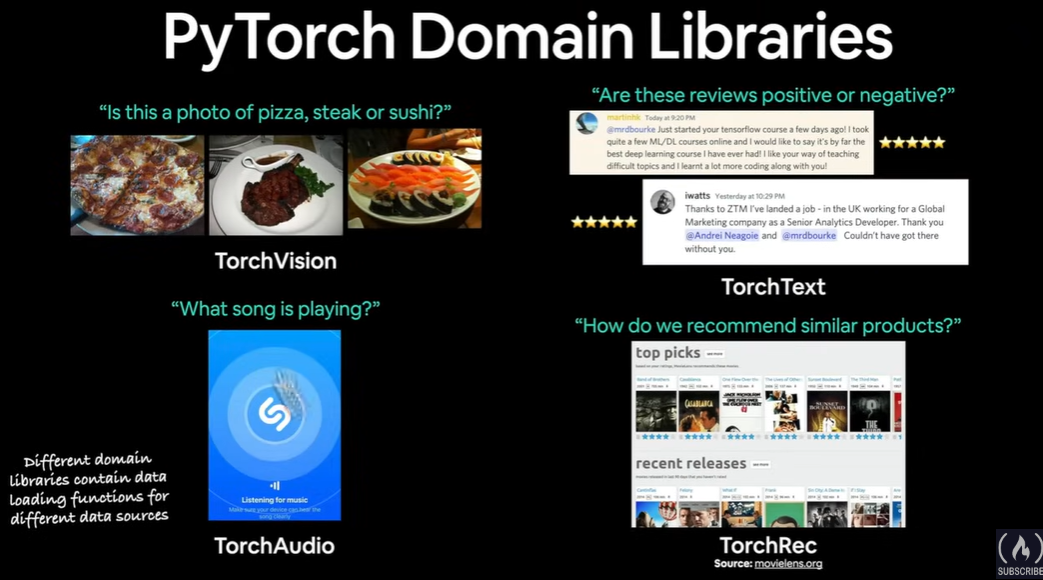

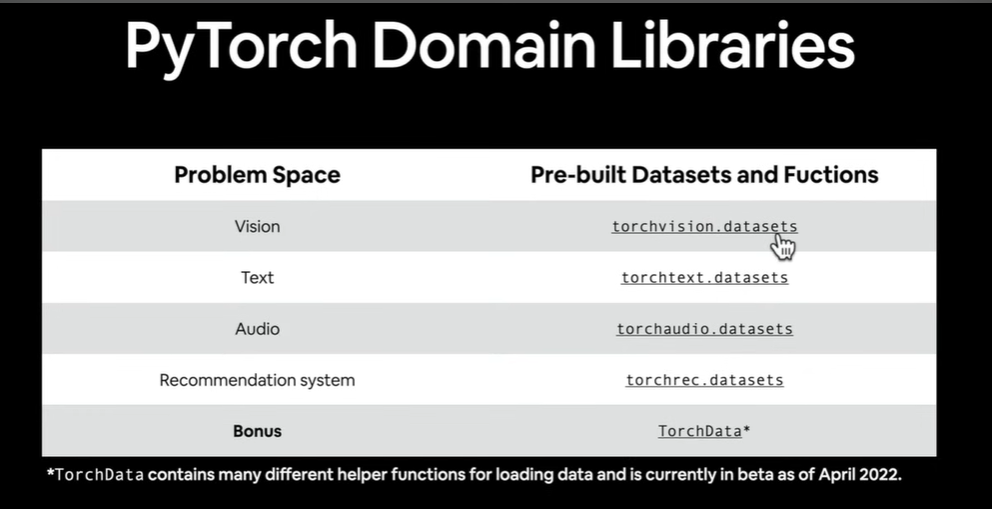

### Importing PyTorch and setting up the device agnotic code

In [ ]:
import torch
from torch import nn

torch.__version__

'2.3.0+cu121'

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Getting the data

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and suhsi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, suhsi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists... skipping download
Unzipping pizza, steak and sushi data...


### Data Preparation, Data Exploration

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [ ]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### Visualizing the image

In [ ]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/sushi/840444.jpg
Image class: sushi
Image height: 512
Image width: 512


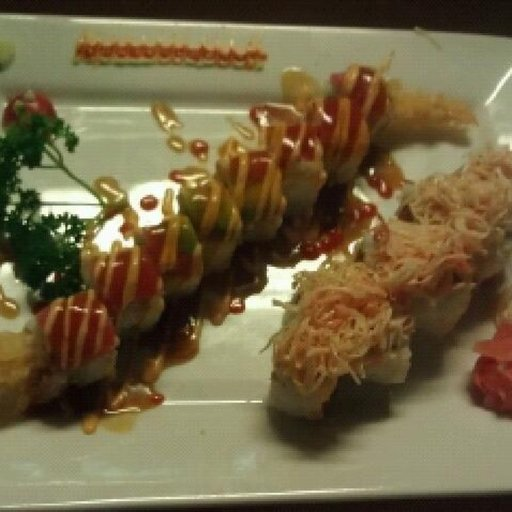

In [ ]:
import random
from PIL import Image

# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

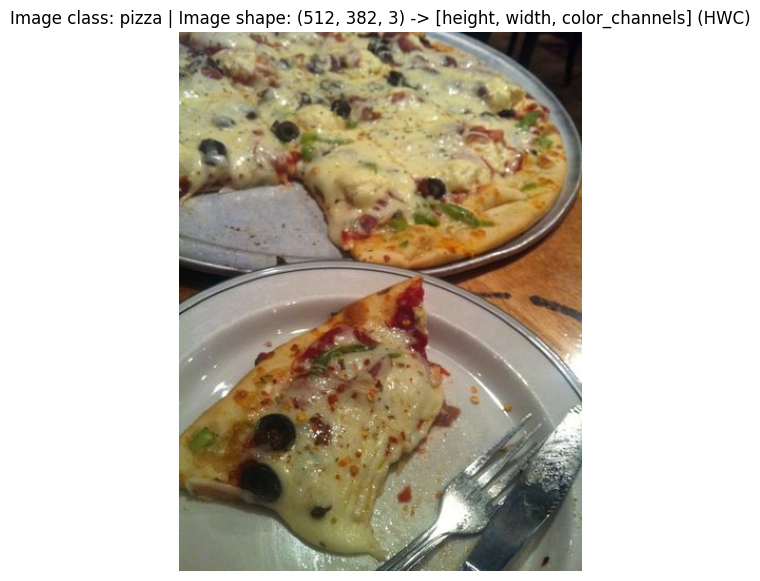

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False);

array([[[126, 114,  90],
        [127, 115,  91],
        [125, 110,  87],
        ...,
        [  4,   3,   9],
        [  5,   4,  10],
        [  5,   4,  10]],

       [[114, 102,  80],
        [117, 105,  83],
        [117, 102,  81],
        ...,
        [  5,   4,  10],
        [  5,   4,  10],
        [  5,   4,  10]],

       [[105,  90,  71],
        [108,  93,  74],
        [108,  93,  74],
        ...,
        [  5,   4,  10],
        [  5,   4,  10],
        [  5,   4,  10]],

       ...,

       [[120, 120,  96],
        [123, 123,  99],
        [124, 123, 102],
        ...,
        [124, 131, 123],
        [123, 130, 122],
        [122, 129, 121]],

       [[118, 116,  91],
        [122, 120,  95],
        [123, 121, 100],
        ...,
        [124, 131, 123],
        [122, 129, 122],
        [121, 128, 121]],

       [[115, 114,  86],
        [120, 118,  93],
        [121, 119,  96],
        ...,
        [123, 130, 122],
        [121, 128, 121],
        [120, 127, 120]]], dtype=uint8)
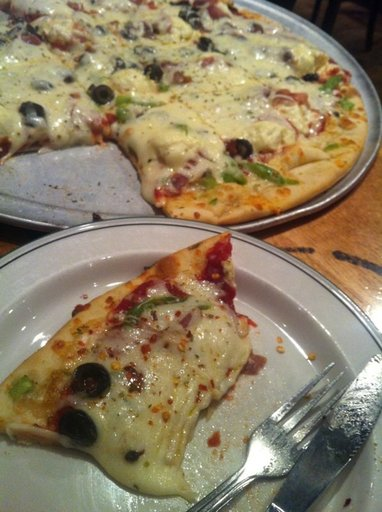

In [ ]:
img_as_array

### Transforming data

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(64, 64)),
  # Flip the images randomly on the horizontal
  transforms.RandomHorizontalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor()
])

In [ ]:
data_transform(img).shape

torch.Size([3, 64, 64])

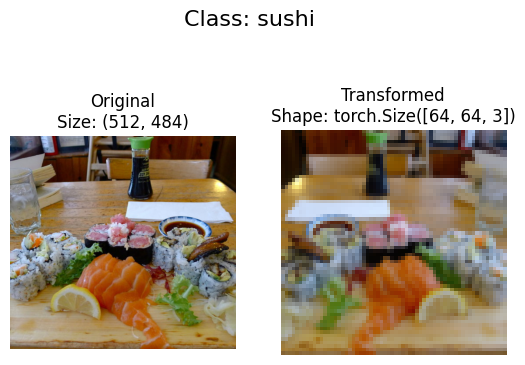

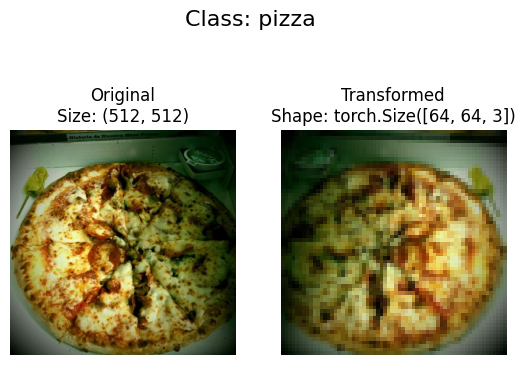

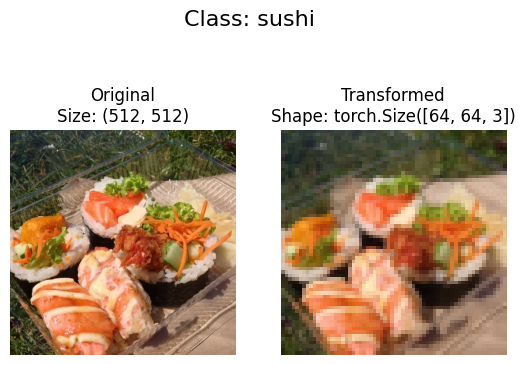

In [ ]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # note we will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=None)

### Loading image

In [ ]:
from torchvision import datasets

train_data= datasets.ImageFolder(root=train_dir, transform=data_transform,target_transform=None)
test_data= datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
#Get class names as dict
class_to_idx = train_data.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
#Check the length of dataset
len(train_data),len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
train_data[0][0]

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [ ]:
#Index on train_data Dataset to get a single image and label

image,label = train_data[0][0],train_data[0][1]

print(f"Image tensor: {img}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x7D5A11B75C90>
Image shape: torch.Size([3, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


Original shape: torch.Size([3, 64, 64])
Image permuted shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

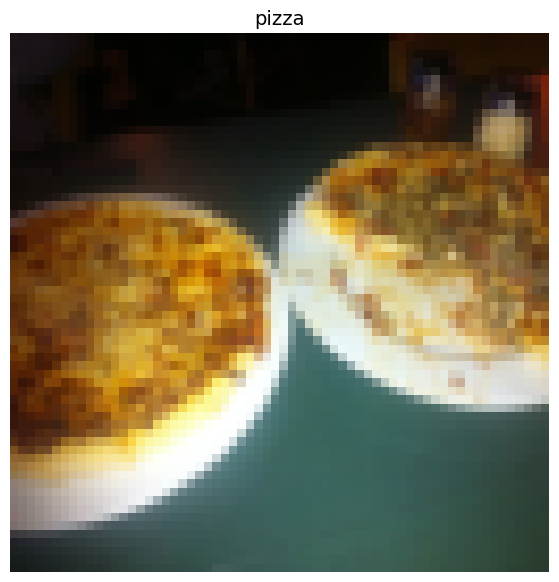

In [ ]:
# Rearrange the order dimensions
img_permuted = image.permute(1,2,0)

#Print out different shapes
print(f"Original shape: {image.shape}")
print(f"Image permuted shape: {img_permuted.shape}")

#Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permuted)
plt.axis(False)
plt.title(class_names[label],fontsize=14)

### Turn loaded images into DataLoader's

In [ ]:
import os
os.cpu_count()

2

In [ ]:
#Turn the train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader= DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())
test_dataloader= DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count())

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7d59f98ca950>,
 <torch.utils.data.dataloader.DataLoader at 0x7d59f98665c0>)

In [ ]:
len(train_dataloader),len(test_dataloader)

(225, 75)

In [ ]:
img,label = next(iter(train_dataloader))

#Batch size will now be 1 you can change the batch size if you like
print(f"Image shape: {img.shape}")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64])
Label shape: torch.Size([1])


### Creating custom datasets without using ImageFolder() of pytorch

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
#Instance of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Creating a helper function to get the class names

Required Functions:
1. Get the class names using os.scandir() to traverse a target directory(this directory needs to be in the standard image classification format)
2. Raise an error if the class names are not found
3. Turn the class names into a dict and a list and return them

In [ ]:
#Setup path for target directory
target_directory=train_dir
print(f"Target dir: {target_directory}")

#Getting the class names
class_names = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  '''
  Find the class folder names in the target directory
  '''
  class_names = sorted([entry.name for entry in list(os.scandir(directory))])

  if not class_names:
    raise FileNotFoundError(f"Could not find class names in {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

  return class_names, class_to_idx

In [ ]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Create a custom `Dataset` to replicate `ImageFolder`
1. Subclass `torch.utils.data.Dataset`
2. `Init our subclass` with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
* `paths` - paths of our images
* `transform` - the transform we'd like to use
* `classes` - a list of the target classes
* `class_to_idx`- a dict of the target classes mapped to integer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [ ]:
from torch.utils.data import Dataset

#Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #Intialize custom dataset
  def __init__(self, target_dir: str, transform=None):
    #Create class attributes
    #Get all image paths
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))

    #Setup transform
    self.transform = transform

    #Get classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(target_dir)

  #Function to load the image
  def load_image(self, index:int) -> Image.Image:
    '''
    Opens an image via its path and returns it
    '''
    image_path = self.paths[index]
    return Image.open(image_path)

  #Overwrite the __len__()
  def __len__(self) -> int:
    return len(self.paths)

  #Overwrite the __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.Tensor,int]:
    '''
    Returns one sample of data, data and label (X,y)
    '''
    #Load the image
    image = self.load_image(index)

    class_name=self.paths[index].parent.name
    #path must be in this format: data_folder/class_name/image.jpg
    class_idx=self.class_to_idx[class_name]

    #Transform the image (if neccessary)
    if self.transform:
      image=self.transform(image)

    return image,class_idx
    #return data,label (X,y)

In [ ]:
train_data[0]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [ ]:
#Create a transform
from torchvision import transforms

train_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
#Test out ImageFolderCustom
train_data_custom=ImageFolderCustom(
    target_dir=train_dir,
    transform=train_transforms
)

test_data_custom=ImageFolderCustom(
    target_dir=test_dir,
    transform=test_transforms
)

In [ ]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7d59f9801060>,
 <__main__.ImageFolderCustom at 0x7d59f9803460>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True
